# Assignment 7

**Name: Mrunmayee Khilare**  

**USC ID: 2849110690**  

**GitHub Username: mrunmayee2003**


# Q1. Multi-class and Multi-Label Classification Using Support Vector Machines

In [11]:
# imports, paths, utilities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

random_state = 552
np.random.seed(random_state)


In [52]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

**Q1. (a) Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.**

In [12]:
data_path = "../data/Frogs_MFCCs.csv"  

In [13]:
df = pd.read_csv(data_path)

In [82]:
print("Columns:", list(df.columns))

Columns: ['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6', 'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11', 'MFCCs_12', 'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16', 'MFCCs_17', 'MFCCs_18', 'MFCCs_19', 'MFCCs_20', 'MFCCs_21', 'MFCCs_22', 'Family', 'Genus', 'Species', 'RecordID']


In [83]:
print("Shape:", df.shape)

Shape: (7195, 26)


In [ ]:
feature_columns = [col for col in df.columns if col.startswith("MFCCs")] #there is a space between MFCC 1, to manoeuvre around that

print("Number of MFCC features:", len(feature_columns))
print("MFCC feature columns:", feature_columns)

X = df[feature_columns].copy()   

col_labels = ["Family", "Genus", "Species"]
Y_raw = df[col_labels].copy()

print("X shape:", X.shape)
print("Y_raw shape:", Y_raw.shape)


Number of MFCC features: 22
MFCC feature columns: ['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6', 'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11', 'MFCCs_12', 'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16', 'MFCCs_17', 'MFCCs_18', 'MFCCs_19', 'MFCCs_20', 'MFCCs_21', 'MFCCs_22']
X shape: (7195, 22)
Y_raw shape: (7195, 3)


In [16]:
# encode each label 
encoders = {}
Y = np.zeros((len(df), len(col_labels)), dtype=int)

for j, col in enumerate(col_labels):
    le = LabelEncoder()
    Y[:, j] = le.fit_transform(Y_raw[col].astype(str))
    encoders[col] = le

print("X shape:", X.shape)
print("Y shape:", Y.shape, "(columns order:", col_labels, ")")

X shape: (7195, 22)
Y shape: (7195, 3) (columns order: ['Family', 'Genus', 'Species'] )


Many algorithms cannot handle string labels.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=random_state, stratify=Y[:, 2])

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)

Train: (5036, 22) (5036, 3)
Test : (2159, 22) (2159, 3)


**(b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:**


**i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.**

We have three different labels in this dataset: Family, Genus, and Species. We have to use different metrics because a prediction can be partially correct or partially wrong.

**Exact Match Score:** It checks whether the model predicts all the labels corrrectly. Exact match score is generally used for text classification. It's considered as one of the strictest evaluation metric in multilabel classification because it requires perect match between the predicted and true labels. In this implementation, a prediction is only counted true if all the labels match the true labels.

Even if the model correctly predicts Family and Genus but gets Species wrong, that sample is counted as incorrect.

A high exact match score means the model is doing a good job predicting the entire label combination correctly.

**Hamming Score:** Hamming score will consider the partially correct predictions. It checks each label independently, and a smaller hamming score means that the model made just a few incorrect predictions. The best possible value is 1, that means the model got alkl the predictions right.

Hamming score = (TN + TP) / (TP + FP + TN + FN)

**Hamming Loss:** The Hamming loss is the fraction of labels that are incorrectly predicted. We would ideally ant the Hamming loss to be 0, which would mean that there is no error in prediction.
Hamming loss is less strict than exact match because it allows some labels to be correct and some to be wrong, and it averages that out.



In [24]:
def exact_match_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.all(y_true == y_pred, axis=1))

In [25]:
def hamming_loss(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mismatches = (y_true != y_pred).sum()
    total_labels = y_true.size
    return mismatches / total_labels

In [26]:
def hamming_score(y_true, y_pred):
    return 1 - hamming_loss(y_true, y_pred)

In [ ]:
yt = np.array([[0,1,2],[1,0,0],[2,2,1]])

yp = np.array([[0,1,2],[1,1,0],[2,2,0]])  

print("Exact match score:", exact_match_score(yt, yp))   
print("Hamming loss:", hamming_loss(yt, yp))            
print("Hamming score:", hamming_score(yt, yp))          


Exact match score: 0.3333333333333333
Hamming loss: 0.2222222222222222
Hamming score: 0.7777777777777778


- When we compute the exact match score, we check whether the entire set of labels for a sample is predicted correctly. In this example, only one of the three samples has all labels predicted correctly. This gives an exact match score of one third.

- Hamming loss treats each label independently. It measures the fraction of labels that do not match between yt and yp. Out of the nine total label entries in this example, two are incorrect.

- A smaller Hamming loss means better performance. Since most labels are correct, the loss here is fairly low.

**Q1) ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.**

In [ ]:
# Q1(b)(ii) Raw Features

random_state = 552

In [19]:
# parameter ranges 
C_values = [10**k for k in range(-3, 7)]  
sigma_values = np.linspace(0.1, 2.0, 20) 
gamma_values = [1 / (2 * s**2) for s in sigma_values]

In [ ]:
param_grid = {"estimator__C": C_values,"estimator__gamma": gamma_values,}

In [21]:
results_raw = {}
best_models_raw = {}

In [22]:
for i, label in enumerate(col_labels):
    print(f"\nTraining SVM for label: {label}")

    ovr_svm = OneVsRestClassifier(
        SVC(kernel="rbf", random_state=random_state)
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    grid = GridSearchCV(
        estimator=ovr_svm,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(X_train, Y_train[:, i])

    best_models_raw[label] = grid.best_estimator_
    results_raw[label] = grid.best_params_

    print("Best parameters:", grid.best_params_)


Training SVM for label: Family
Best parameters: {'estimator__C': 10, 'estimator__gamma': np.float64(3.1249999999999996)}

Training SVM for label: Genus
Best parameters: {'estimator__C': 10, 'estimator__gamma': np.float64(3.1249999999999996)}

Training SVM for label: Species
Best parameters: {'estimator__C': 10, 'estimator__gamma': np.float64(1.0204081632653064)}


In [28]:
Y_pred_raw = np.zeros_like(Y_test)

for i, label in enumerate(col_labels):
    Y_pred_raw[:, i] = best_models_raw[label].predict(X_test)


In [29]:
em_raw = exact_match_score(Y_test, Y_pred_raw)
hl_raw = hamming_loss(Y_test, Y_pred_raw)
hs_raw = hamming_score(Y_test, Y_pred_raw)

print("Raw Feature Performance:")
print("Exact Match Score:", em_raw)
print("Hamming Loss:", hl_raw)
print("Hamming Score:", hs_raw)

Raw Feature Performance:
Exact Match Score: 0.9874942102825383
Hamming Loss: 0.008182800679326849
Hamming Score: 0.9918171993206731


**Interpretation: SVM Using Raw Features:**
- For both the Family and Genus labels, the best performing models selected the same combination of penalty and kernel width. 

- The Species classifier selected a slightly different kernel width, which makes sense because class boundaries at the species level tend to be more detailed and harder to separate.
- Multi label performance is high.
- The exact match score was close to one, meaning that almost all predictions matched all three labels correctly at the same time.
- The Hamming loss was very small and the Hamming score was almost perfect, which means that the vast majority of individual label predictions were correct.
- Even without standardization, the SVM with a Gaussian kernel was able to find clear decision boundaries in the feature space.

In [ ]:
# Q1(b)(ii) Standardized Features

param_grid_standardized = {"clf__estimator__C": C_values,"clf__estimator__gamma": gamma_values,}

In [31]:
best_models_std = {}
results_std = {}

In [ ]:
for i, label in enumerate(col_labels):    
    print(f"Training SVM (standardized) for label: {label}")

    pipe = Pipeline([("scaler", StandardScaler()),("clf", OneVsRestClassifier(SVC(kernel="rbf", random_state=random_state)))])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    grid_std = GridSearchCV(estimator=pipe,param_grid=param_grid_standardized,cv=cv,scoring="accuracy",n_jobs=-1)

    grid_std.fit(X_train, Y_train[:, i])

    best_models_std[label] = grid_std.best_estimator_
    results_std[label] = grid_std.best_params_

    print("Best parameters (standardized):", grid_std.best_params_)

Training SVM (standardized) for label: Family
Best parameters (standardized): {'clf__estimator__C': 10, 'clf__estimator__gamma': np.float64(0.125)}
Training SVM (standardized) for label: Genus
Best parameters (standardized): {'clf__estimator__C': 10, 'clf__estimator__gamma': np.float64(0.125)}
Training SVM (standardized) for label: Species
Best parameters (standardized): {'clf__estimator__C': 10, 'clf__estimator__gamma': np.float64(0.125)}


In [38]:
Y_pred_std = np.zeros_like(Y_test)

for i, label in enumerate(col_labels):
    Y_pred_std[:, i] = best_models_std[label].predict(X_test)

em_std = exact_match_score(Y_test, Y_pred_std)
hl_std = hamming_loss(Y_test, Y_pred_std)
hs_std = hamming_score(Y_test, Y_pred_std)

print("Results for Standardized Features")
print("Exact Match Score:", em_std)
print("Hamming Loss     :", hl_std)
print("Hamming Score    :", hs_std)


Results for Standardized Features
Exact Match Score: 0.9814729041222788
Hamming Loss     : 0.013123359580052493
Hamming Score    : 0.9868766404199475


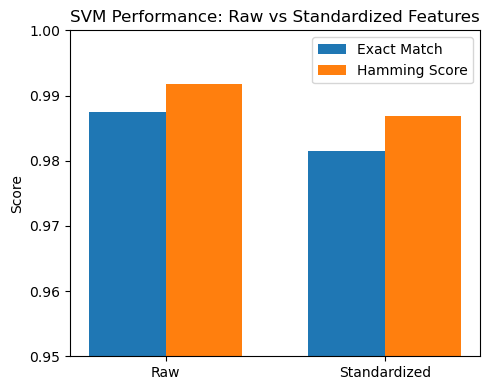

In [106]:
models = ["Raw", "Standardized"]

exact_match = [0.9875, 0.9815]
hamming_score = [0.9918, 0.9869]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(x - width/2, exact_match, width, label="Exact Match")
plt.bar(x + width/2, hamming_score, width, label="Hamming Score")

plt.xticks(x, models)
plt.ylim(0.95, 1.0)

plt.ylabel("Score")
plt.title("SVM Performance: Raw vs Standardized Features")
plt.legend()

plt.tight_layout()
plt.show()


**Selected SVM Penalty Weight and Gaussian Kernel Width**

Using raw features:

Family: C = 10, gamma = 3.125

Genus: C = 10, gamma = 3.125

Species: C = 10, gamma = 1.0204

Using standardized features:

Family: C = 10, gamma = 0.125

Genus: C = 10, gamma = 0.125

Species: C = 10, gamma = 0.125

**Interpretation: SVM Using Standardized Features:**
- All three SVM models selected the same combination of penalty and kernel width. This suggests that once the scales are aligned, the models see a more uniform structure across the three label levels.

- The performance remained strong, but there was a small drop compared to the raw feature setting.

- Even though the change was small, it shows that the raw MFCC values were already in a favourable scale for the RBF kernel.

- The model is able to separate the classes well, and the standardized features did not harm performance dramatically.


**Comparison:**

- Raw features gave the stronger results.

- The performance drop after standardization suggests that the MFCC features were already naturally scaled in a way that worked well with the Gaussian kernel.

- Data is already normalized so the raw values often carry meaningful relative magnitudes. When we standardized the attributes, we removed these natural scale relationships, and the SVM became slightly less effective at separating the classes.

- Standardization is usually recommended for SVMs because the RBF kernel can behave unpredictably when features are on very different scales. However, in some cases the data is already suitable.

- This dataset is a good example of the case where the raw data already has a suitable scale. As a result, standardization did not provide an advantage and in fact slightly reduced performance.

**Q1. (b) iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4 the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.**

In [39]:
C_values_l1 = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [40]:
param_grid_l1 = {"clf__estimator__C": C_values_l1}

In [41]:
best_models_l1 = {}
results_l1 = {}

In [ ]:
for i, label in enumerate(col_labels):   
    print(f"Training L1-penalized SVM (standardized) for label: {label}")

    pipe_l1 = Pipeline([
        ("scaler", StandardScaler()),("clf", OneVsRestClassifier(LinearSVC(penalty="l1",dual=False,random_state=random_state,max_iter=5000)))])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    grid_l1 = GridSearchCV(estimator=pipe_l1,param_grid=param_grid_l1,cv=cv,scoring="accuracy",n_jobs=-1)

    grid_l1.fit(X_train, Y_train[:, i])

    best_models_l1[label] = grid_l1.best_estimator_
    results_l1[label] = grid_l1.best_params_

    print("Best parameters (L1, standardized):", grid_l1.best_params_)


Training L1-penalized SVM (standardized) for label: Family
Best parameters (L1, standardized): {'clf__estimator__C': 1}

Training L1-penalized SVM (standardized) for label: Genus
Best parameters (L1, standardized): {'clf__estimator__C': 10}

Training L1-penalized SVM (standardized) for label: Species
Best parameters (L1, standardized): {'clf__estimator__C': 1}


In [44]:
### Q1(b)(iii) Evaluation – L1-penalized SVMs

Y_pred_l1 = np.zeros_like(Y_test)

for i, label in enumerate(col_labels):
    Y_pred_l1[:, i] = best_models_l1[label].predict(X_test)

em_l1 = exact_match_score(Y_test, Y_pred_l1)
hl_l1 = hamming_loss(Y_test, Y_pred_l1)
hs_l1 = hamming_score(Y_test, Y_pred_l1)

print("Results forL1-penalized SVMs (Standardized)")
print("Exact Match Score:", em_l1)
print("Hamming Loss     :", hl_l1)
print("Hamming Score    :", hs_l1)


Results forL1-penalized SVMs (Standardized)
Exact Match Score: 0.9166280685502547
Hamming Loss     : 0.05094951366373321
Hamming Score    : 0.9490504863362668


**Selected Penalty Weights for L1 Penalized SVMs**

Using standardized features:

Family: C = 1

Genus: C = 10

Species: C = 1

Performance:

Exact Match Score: 0.9166

Hamming Loss: 0.05095

Hamming Score: 0.94905

**Interpretation:**

- The L1-penalized SVM results showed noticeably weaker performance compared to the RBF SVMs trained earlier.

- This might be due to the fact that the L1 penalty forces the model to produce sparse weight vectors and the classifiers rely only on a subset of the MFCC features to make decisions.

- Family and Species preferred a smaller penalty value, while the Genus classifier selected a larger value.

- Genus classification seems to require more regularization, while Family and Species benefit from allowing more model flexibility.

- The exact match score dropped, meaning that fewer predictions matched all three labels correctly at the same time.

- The Hamming score also declined and the Hamming loss increased, which shows that the model made more mistakes on individual labels.

**iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.**

In [46]:
random_state = 552

In [47]:
best_models_l1_smote = {}
results_l1_smote = {}

In [48]:
C_values_l1 = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [ ]:
param_grid_l1 = {"clf__estimator__C": C_values_l1}

In [ ]:
for i, label in enumerate(col_labels):   
    print(f"Training L1 SVM with SMOTE for label: {label}")

    pipe_l1_smote = ImbPipeline([("smote", SMOTE(random_state=random_state)),("scaler", StandardScaler()),("clf", OneVsRestClassifier(LinearSVC(enalty="l1",dual=False,random_state=random_state,max_iter=5000)))])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    grid_l1_smote = GridSearchCV(estimator=pipe_l1_smote,param_grid=param_grid_l1,cv=cv,scoring="accuracy",n_jobs=-1)

    grid_l1_smote.fit(X_train, Y_train[:, i])

    best_models_l1_smote[label] = grid_l1_smote.best_estimator_
    results_l1_smote[label] = grid_l1_smote.best_params_

    print("Best parameters (SMOTE + L1):", grid_l1_smote.best_params_)



Training L1 SVM with SMOTE for label: Family
Best parameters (SMOTE + L1): {'clf__estimator__C': 10}

Training L1 SVM with SMOTE for label: Genus


/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the n

Best parameters (SMOTE + L1): {'clf__estimator__C': 100}

Training L1 SVM with SMOTE for label: Species


/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the n

Best parameters (SMOTE + L1): {'clf__estimator__C': 0.1}


In [84]:
Y_pred_l1_smote = np.zeros_like(Y_test)

for i, label in enumerate(col_labels):
    Y_pred_l1_smote[:, i] = best_models_l1_smote[label].predict(X_test)

em_l1_smote = exact_match_score(Y_test, Y_pred_l1_smote)
hl_l1_smote = hamming_loss(Y_test, Y_pred_l1_smote)
hs_l1_smote = hamming_score(Y_test, Y_pred_l1_smote)

print("L1 SVM (SMOTE) Performance:")
print("Exact Match Score:", em_l1_smote)
print("Hamming Loss     :", hl_l1_smote)
print("Hamming Score    :", hs_l1_smote)


L1 SVM (SMOTE) Performance:
Exact Match Score: 0.8666049096804076
Hamming Loss     : 0.06978539447274973
Hamming Score    : 0.9302146055272502


**Best Penalty Values (C) Found Using 10-Fold Cross-Validation**

Family: best C = 10

Genus: best C = 100

Species: best C = 0.1

**Overall Performance with SMOTE**

Exact Match Score: 0.8666

Hamming Loss: 0.0698

Hamming Score: 0.9302

- Genus classifier needed a much stronger penalty, which often happens when the classes overlap more or require more flexibility to separate.

- Using SMOTE actually made the L1-penalized SVM perform worse.



- This can happen due to a number of reasons:

1. SMOTE creates synthetic points along the line between minority samples, but these synthetic samples may not match the true structure of the frog call data.

2. L1-penalized linear SVMs already struggle with capturing complex class boundaries. By adding synthetic points, the classes might look even less linearly separable, making the model’s job harder.

Using SMOTE did not help the L1-regularized linear SVM. The results became noticeably worse than the version without oversampling. For this dataset, L1-penalized models are not strong enough to take advantage of SMOTE, and the synthetic samples may have added noise rather than useful structure.

L1 SVM without SMOTE performed better, which shows that balancing the classes artificially is not always beneficial, especially when the original feature space is already well separated.

# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

**Monte Carlo Simulation:**
A Monte-Carlo Simulation is a general technique where we repeat the same experiment many times, each time with some randomness, and then we look at the average behavior of the results.

**(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not splitthe data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈{1, 2, . . . , 50}automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.**

In [55]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

In [56]:
random_state = 552

In [ ]:
# Loading the full dataset
X_full = X  
Y_full = Y_raw  

In [ ]:
# Standardizing the features for k-means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

In [ ]:
# choosing k using CH index automatically
k_values = range(2, 51)
ch_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = km.fit_predict(X_scaled)
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

best_k = k_values[np.argmax(ch_scores)]
print("Best k according to CH index:", best_k)

Best k according to CH index: 2


The Calinski–Harabasz method suggested that the data naturally forms two main clusters.
Even though the dataset contains many families, genus, and species, the MFCC features do not necessarily form many clean, separate clusters.

K-Means algorithm finds only two large groups that are well separated in terms of overall acoustics.

In [ ]:
# encodings
family_onehot  = pd.get_dummies(Y_full["Family"])
genus_onehot   = pd.get_dummies(Y_full["Genus"])
species_onehot = pd.get_dummies(Y_full["Species"])


Y_onehot = np.hstack([family_onehot, genus_onehot, species_onehot])
print("One-hot label shape:", Y_onehot.shape)   # should be (7195, 22)

One-hot label shape: (7195, 22)


In [73]:
def hamming_distance(A, B):
    return np.mean(A != B)

In [ ]:
# 50 runs of Monte Carlo simulation
hamming_distances = []

for i in range(50):
    km = KMeans(
        n_clusters=best_k,
        random_state=552 + i,
        n_init=10
    )
    cluster_labels = km.fit_predict(X_scaled)   

    # assign majority labels to each cluster
    df_labels = Y_full.copy()
    df_labels["cluster"] = cluster_labels

    Y_pred_list = []

    for c in range(best_k):
        cluster_rows = df_labels[df_labels["cluster"] == c]

        if len(cluster_rows) == 0:
            majority_family  = Y_full["Family"].mode()[0]
            majority_genus   = Y_full["Genus"].mode()[0]
            majority_species = Y_full["Species"].mode()[0]
        else:
            majority_family  = cluster_rows["Family"].mode()[0]
            majority_genus   = cluster_rows["Genus"].mode()[0]
            majority_species = cluster_rows["Species"].mode()[0]

        mask = (df_labels["cluster"] == c)
        Y_pred_list.append(
            pd.DataFrame({
                "Family":  majority_family,
                "Genus":   majority_genus,
                "Species": majority_species
            }, index=df_labels[mask].index)
        )

    # concatenate all predicted labels
    Y_pred_df = pd.concat(Y_pred_list).sort_index()
    Y_true_df = Y_full[["Family", "Genus", "Species"]].sort_index()

    combined = pd.concat([Y_true_df, Y_pred_df], axis=0)
    combined_dummies = pd.get_dummies(combined)

    n = len(Y_true_df)
    Y_true_oh = combined_dummies.iloc[:n].to_numpy()
    Y_pred_oh = combined_dummies.iloc[n:].to_numpy()

    # Hamming distance
    hd = hamming_distance(Y_true_oh, Y_pred_oh)
    hamming_distances.append(hd)


In [77]:
mean_hd = np.mean(hamming_distances)
std_hd = np.std(hamming_distances)

In [79]:
hamming_distances

[np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.08128119274748878),
 np.float64(0.

In [78]:
print("Monte Carlo (50 runs) Hamming Distance:")
print("Mean:", mean_hd)
print("Std :", std_hd)

Monte Carlo (50 runs) Hamming Distance:
Mean: 0.08128119274748878
Std : 0.0


**Interpretation:**

Across all 50 runs, the Hamming distances were identical, and the summary statistics were:

Mean Hamming Distance: 0.0813

Standard Deviation: 0.0

- The Hamming Distance remained the same during all 50 runs.
- This says that the clustering is very stable. The randomness inside k means did not create any variation in how instances were grouped.

- A Hamming Distance around 0.08 means that only about 8 percent of the labels (Family, Genus, and Species) were assigned incorrectly when using majority voting per cluster.

- Because the standard deviation is exactly zero, the algorithm converged to the same clusters and same label assignments every single time.

**Conclusion**

The Monte-Carlo experiment shows extremely stable clusters, meaning that the K-Means solution is not sensitive to initialization in this dataset when using the chosen number of clusters. 

The mislabeling rate is moderate, which shows the challenge of matching a simple unsupervised clustering method with a complex multi-label classification problem.

**b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.**

In [ ]:
labels_df = Y_full.reset_index(drop=True)
k = len(np.unique(cluster_labels))
print(f"Number of clusters = {k}")

majority_labels = []

for c in range(k):
    print(f"\nCluster {c}:- ")

    idx = np.where(cluster_labels == c)[0]
    cluster_true = labels_df.iloc[idx]

    # Family
    fam_major = cluster_true['Family'].value_counts().idxmax()
    # Genus
    gen_major = cluster_true['Genus'].value_counts().idxmax()
    # Species
    sp_major  = cluster_true['Species'].value_counts().idxmax()
    
    majority_labels.append((fam_major, gen_major, sp_major))
    
    print("Majority Family :", fam_major)
    print("Majority Genus  :", gen_major)
    print("Majority Species:", sp_major)


Number of clusters = 2

Cluster 0:- 
Majority Family : Hylidae
Majority Genus  : Hypsiboas
Majority Species: HypsiboasCordobae

Cluster 1:- 
Majority Family : Leptodactylidae
Majority Genus  : Adenomera
Majority Species: AdenomeraHylaedactylus


**Interpretation:**

Cluster 0--

- The most common Family is Hylidae

- The most common Genus is Hypsiboas

- The most common Species is HypsiboasCordobae

Cluster 1--

- The most common Family is Leptodactylidae

- The most common Genus is Adenomera

- The most common Species is AdenomeraHylaedactylus

Frogs in Cluster 0 tend to come from one dominant group of tree frogs. Their patterns probably share strong similarities, which explains why k means grouped them together.

Cluster 1 is dominated by a different biological group. These frogs likely produce calls that are distinct from Cluster 0, causing the algorithm to place them in a separate cluster.

**(c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss5 between the true labels and the labels assigned by clusters.**

In [95]:
import numpy as np
import pandas as pd

Y_true = Y_full[['Family', 'Genus', 'Species']].reset_index(drop=True)

In [96]:
# converting majority_labels to a lookup array
majority_labels = np.array(majority_labels)  

In [97]:
# labels based on clusters
Y_pred = np.zeros_like(Y_true, dtype=object)

In [98]:
for i in range(len(cluster_labels)):
    c = cluster_labels[i]
    Y_pred[i] = majority_labels[c]

In [99]:
def hamming_distance(true, pred):
    return np.mean(true != pred)

In [100]:
def hamming_score(true, pred):
    return np.mean(true == pred)

In [102]:
def hamming_loss(true, pred):
    return np.mean(true != pred)

In [103]:
HD  = hamming_distance(Y_true.values, Y_pred)
HS  = hamming_score(Y_true.values, Y_pred)
HL  = hamming_loss(Y_true.values, Y_pred)

In [104]:
print("Results:")
print("Hamming Distance:", HD)
print("Hamming Score   :", HS)
print("Hamming Loss    :", HL)

Results:
Hamming Distance: 0.29803104007412556
Hamming Score   : 0.7019689599258745
Hamming Loss    : 0.29803104007412556


**Interpretation: Hamming Distance, Hamming Score, and Hamming Loss**

Hamming Distance: 0.2980

Hamming Score: 0.7020

Hamming Loss: 0.2980

The Hamming distance and Hamming loss are the same in this setting because both measure the proportion of incorrect label predictions across all three label positions. A value around 0.298 means that about 30 percent of the individual labels (Family, Genus, Species) were assigned incorrectly by the clustering model.

The Hamming score is simply one minus the Hamming loss, so a value of 0.702 means that about 70 percent of all label positions were predicted correctly.

K-means clustering does not use labels at all, so these results make sense. Yet still achieving about 70 percent correctness, despite completely unsupervised learning, suggests that:

The features contain meaningful structure related to frog families, genera, and species.

The clusters roughly capture two broad groups.

However, clustering alone cannot fully recover the detailed classification, which is why the error remains close to 30 percent.

**ISLR 12.6.2**


Labelling observations as 1,2,3,4. The dissimilarities are:
d(1,2) = 0.3

d(1,3) = 0.4

d(1,4) = 0.7

d(2,3) = 0.5

d(2,4) = 0.8

d(3,4) = 0.45

In [64]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [65]:
D = np.array([[0.0, 0.3, 0.4, 0.7],[0.3, 0.0, 0.5, 0.8],[0.4, 0.5, 0.0, 0.45],[0.7, 0.8, 0.45, 0.0]])

In [66]:
D_condensed = squareform(D)

In [67]:
labels = ["1", "2", "3", "4"]

**(a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.**

In [68]:
Z_complete = linkage(D_condensed, method="complete")

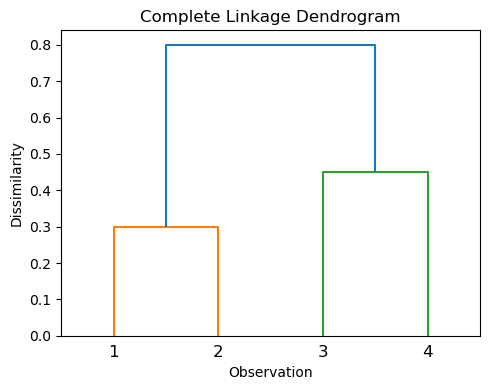

In [69]:
plt.figure(figsize=(5, 4))
dendrogram(Z_complete, labels=labels)
plt.title("Complete Linkage Dendrogram")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

Complete linkage defines the distance between two clusters as the maximum pairwise distance between points in the two clusters.

The smallest dissimilarity is 0.3 so observations 1 and 2 merge first at height 0.3.

Comparing clusters:

d({1,2}, 3) = max(d(1,3), d(2,3)) = max(0.4, 0.5) = 0.5

d({1,2}, 4) = max(d(1,4), d(2,4)) = max(0.7, 0.8) = 0.8

d(3,4) = 0.45

The smallest of these is 0.45 so 3 and 4 merge at height 0.45.

Merging the two clusters {1,2} and {3,4}. 

The distance is
d({1,2},{3,4}) = max(0.4, 0.5, 0.7, 0.8) = 0.8, the final merge happens at height 0.8.


So the complete linkage dendrogram:

1 and 2 join at 0.3

3 and 4 join at 0.45

{1,2} and {3,4} join at 0.8

**(b) Repeat (a), this time using single linkage clustering.**

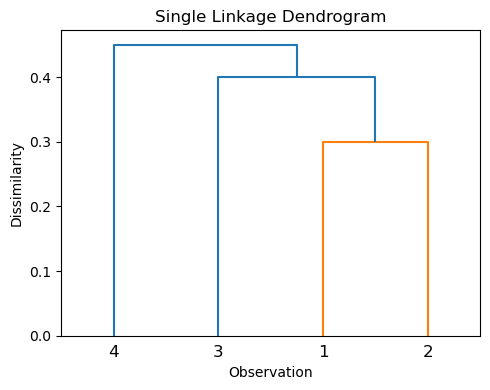

In [88]:
Z_single = linkage(D_condensed, method="single")

plt.figure(figsize=(5, 4))
dendrogram(Z_single, labels=labels)
plt.title("Single Linkage Dendrogram")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

Single linkage defines the distance between two clusters as the minimum pairwise distance between points in the two clusters.

The smallest dissimilarity is 0.3 so 1 and 2 merge first at height 0.3.

Now we have clusters {1,2}, 3 and 4:

d({1,2}, 3) = min(d(1,3), d(2,3)) = min(0.4, 0.5) = 0.4

d({1,2}, 4) = min(d(1,4), d(2,4)) = min(0.7, 0.8) = 0.7

d(3,4) = 0.45

The smallest is 0.4 so cluster {1,2} merges with 3 at height 0.4, forming {1,2,3}.

The distance between {1,2,3} and 4 is
d({1,2,3}, 4) = min(d(1,4), d(2,4), d(3,4)) = min(0.7, 0.8, 0.45) = 0.45.
So 4 joins at height 0.45.

So the single linkage dendrogram:

1 and 2 join at 0.3

{1,2} joins with 3 at 0.4

{1,2,3} joins with 4 at 0.45

**(c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?**


Final merge in (a) is at height 0.8.
Cutting between 0.45 and 0.8 gives two clusters:

Cluster 1: {1, 2}

Cluster 2: {3, 4}

**(d) Suppose that we cut the dendrogram obtained in (b) such that
two clusters result. Which observations are in each cluster?**

Final merge in (b) is at 0.45.

Cutting between 0.4 and 0.45 gives:

Cluster 1: {1, 2, 3}

Cluster 2: {4}

**(e) It is mentioned in this chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be
swapped without changing the meaning of the dendrogram. Draw
a dendrogram that is equivalent to the dendrogram in (a), for
which two or more of the leaves are repositioned, but for which
the meaning of the dendrogram is the same.**


In [89]:
Z_equiv = Z_complete.copy()

print("Original linkage matrix:\n", Z_complete)


Original linkage matrix:
 [[0.   1.   0.3  2.  ]
 [2.   3.   0.45 2.  ]
 [4.   5.   0.8  4.  ]]


In [90]:
Z_equiv[0, 0], Z_equiv[0, 1] = Z_equiv[0, 1], Z_equiv[0, 0]

In [92]:
print("Modified linkage matrix (children swapped in first merge):\n", Z_equiv)


Modified linkage matrix (children swapped in first merge):
 [[1.   0.   0.3  2.  ]
 [2.   3.   0.45 2.  ]
 [4.   5.   0.8  4.  ]]


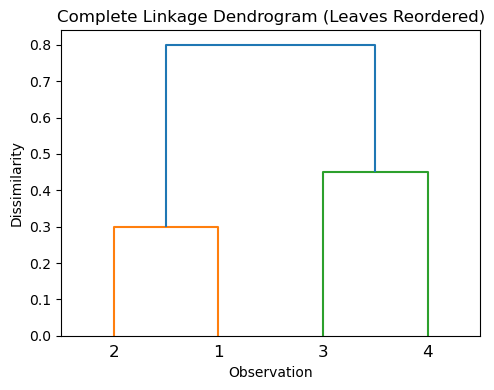

In [94]:
plt.figure(figsize=(5, 4))
dendrogram(Z_equiv, labels=labels)
plt.title("Complete Linkage Dendrogram (Leaves Reordered)")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

References:
- https://permetrics.readthedocs.io/en/latest/pages/classification/HS.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html
- Zhang, M. L., and Zhou, Z. H. (2014). A Review on Multi-Label Learning Algorithms. IEEE Transactions on Knowledge and Data Engineering.
- Tsoumakas, G., and Katakis, I. (2007). Multi Label Classification: An Overview. 
- ISLP: An Introduction to Statistical Learning with Python (2023). James, Witten, Hastie, Tibshirani, and Taylor.
- https://wiki.cloudfactory.com/docs/mp-wiki/metrics/hamming-score
- Grigorios Tsoumakas, Ioannis Katakis. Multi-Label Classification: An Overview. International Journal of Data Warehousing & Mining, 3(3), 1-13, July-September 2007.
- https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html